In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [2]:
# Parameters of the graph
edge_size = 2
node_weight_exp = 1.1
min_occurence_actor = 500
spacing = 10

In [3]:
def plot_cooc_graph(file):
    df = pd.read_csv(file, usecols=['V1Persons']).dropna()
    df['V1Persons'] = df["V1Persons"].str.replace(" ","_")

    # Remove an actor if it appears less than min_occurence_actor times
    act = df.values.flatten().tolist()
    act = ';'.join(act)
    act = act.split(";")
    top_actors = [word for word, occ in Counter(act).items() if occ >= min_occurence_actor]
    df['V1Persons'] = df["V1Persons"].str.replace(";"," ")
    df['V1Persons'] = df['V1Persons'].apply(lambda x: ' '.join([y for y in x.split() if y in top_actors]))
    
    # Create the co-occurence matrix
    docs = df.values.flatten().tolist()
    count_model = CountVectorizer(ngram_range=(1,1)) # default unigram model
    X = count_model.fit_transform(docs)
    Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
    Xc.setdiag(0)
    
    # Capitalize and remove underscore in actor names
    nodes = count_model.get_feature_names()
    nodes = [x.replace("_", " ") for x in nodes]
    nodes = [' '.join([x.capitalize() for x in y.split()]) for y in nodes]
    
    # Create the weighted edge list
    Knz = Xc.nonzero()
    sparserows = Knz[0]
    sparsecols = Knz[1]
    edge_list = [x for x in list(zip(list(sparserows), list(sparsecols))) if x[0] <= x[1]]
    weights = [Xc[x[0], x[1]]*0.001*edge_size for x in edge_list]
    weighted_edge_list = [(x[0][0], x[0][1], x[1]) for x in list(zip(edge_list, weights))]
    weighted_edge_list = [(nodes[x[0]], nodes[x[1]], x[2]) for x in weighted_edge_list]
    
    # Plot the graph
    plt.subplots(figsize=(14,14))
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edge_list)
    vertices = [x for x in G.nodes()]
    vertices = [x.replace(" ", "_") for x in vertices]
    vertices = [x.lower() for x in vertices]
    node_sizes = [Counter(act).get(x)**node_weight_exp for x in vertices]
    pos = nx.spring_layout(G, k=spacing/(G.order()**0.5))
    nx.draw(G, pos, with_labels=True, font_size = 10, font_weight = 'bold',
            width=[G[u][v]['weight'] for u,v in G.edges()], node_size=node_sizes)
    plt.axis('off')
    plt.show()

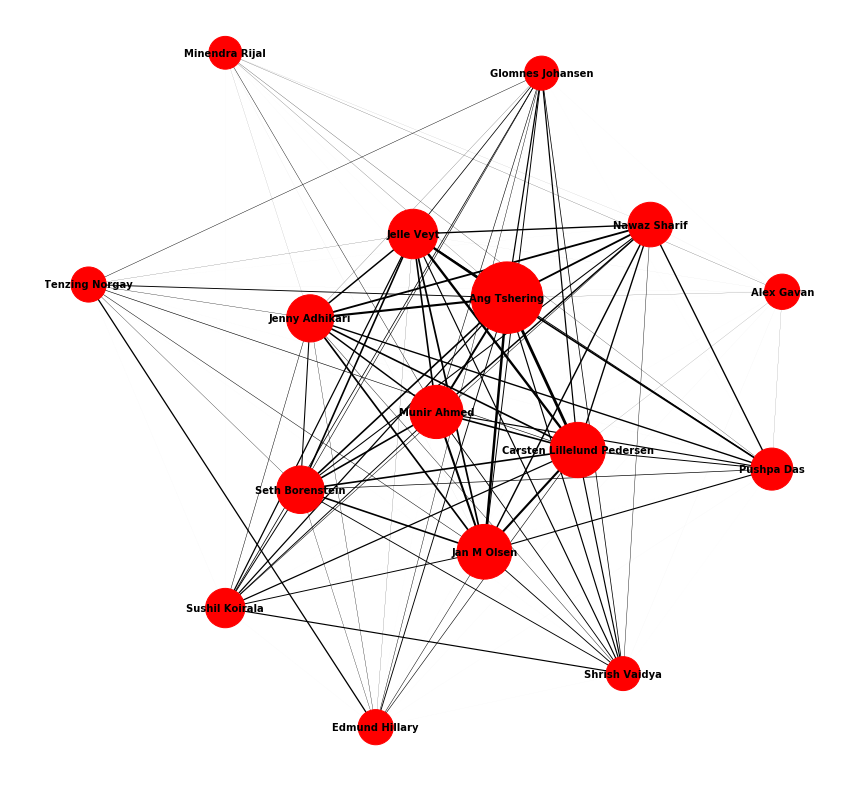

In [5]:
plot_cooc_graph("persons_co-occurences_2015_4_25.csv")